# Prototyping a Respondent Driven Sampling Scenario

Model Definition:
* A node is selected for contact tracing, at the timepoints of a markov process with parameter $\mu$
* Once a node has been selected for contact tracing, a connected node is selected for contact tracing with probability $p$
* After a node has been selected for contact tracing, it is immediately returned to the susceptible state

In other words, it is a simple branching process.

Possible modifications: Only branches along the infected.

# Imports

In [35]:
import sys
sys.path.append('..')
from NetworkEpidemicSimulation.Simulation import complex_epidemic_simulation
from NetworkEpidemicSimulation.DynamicNetworks import dynamic_stochastic_block_model
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering

# RDS Function and Data

In [36]:
#We begin by pre-generating the times at which the respondant driven sampling occurs, and which node initiates the sampling event.
time_between_events = 50
tracing_events = []
total_time = 0
simulation_end_time = 2500
node_keys = range(1000)
while total_time < simulation_end_time:
    new_waiting_time = np.random.exponential(time_between_events)
    total_time += new_waiting_time
    selected_node = np.random.choice(node_keys)
    tracing_events.append((total_time,selected_node))
contact_tracing_prob = 0.21

In [37]:
def contact_tracing_event(self):
    node = [event[1] for event in tracing_events if event[0] > self.time and event[0] < self.time + 0.5]
    if node != []:
        
        current_round = node
        all_traced_nodes = current_round
        
        #If the last round was not empty, a new round of contact tracing is started
        while current_round != []:
            
            #Empty set to store the new round
            new_round = []
        
            #loop over the last round, to see if they do any branches
            for node in current_round:
                for neighbour in list(self.G.neighbors(node)):
                    if neighbour not in all_traced_nodes:
                        if np.random.random() < contact_tracing_prob:
                            new_round.append(neighbour)
                #[new_round.append(neighbour) for neighbour in list(self.G.neighbors(node)) if neighbour not in all_traced_nodes and a.any(np.random.binomial(1,p) == 1)]

            [all_traced_nodes.append(new_node) for new_node in new_round]
            
            current_round = new_round
        #print("Contact Tracing Event:", all_traced_nodes)
        self.update_infection_stage(all_traced_nodes, "Susceptible", self.time)
            

# Simulation Parameters

In [41]:
model = range(3)
community_size = [10,20,100]
number_of_communities = [100,50,10]
repeats = 20
network_connectedness = 1
community_connectedness = 5
N = 1000
beta = 0.00031
infection_period = 1000
max_iter = 6000

# Simulation

In [43]:
results = np.zeros(shape = (3,repeats, max_iter + 1))

for i in model:
    
    
    for j in range(repeats):
        
        # Network Generation Step
        sizes = [community_size[i] for x in range(number_of_communities[i])]
        p = [[network_connectedness/(N-community_size[i]) for x in range(number_of_communities[i])] for y in range(number_of_communities[i])]
        for k in range(number_of_communities[i]):
            p[k][k] = community_connectedness/(community_size[i]-1)
        G = nx.generators.community.stochastic_block_model(sizes, p)
        
        # Set up for Epidemic
        my_network_epidemic = complex_epidemic_simulation(G,
                                                  beta = beta,
                                                  infection_period_parameters = infection_period,
                                                  initial_infected = 321,
                                                  time_increment = 0.5,
                                                  max_iterations = max_iter,
                                                  SIS = True,
                                                  custom_behaviour = contact_tracing_event)
        
        # Run the epidemic
        my_network_epidemic.iterate_epidemic()
        
        time = my_network_epidemic.data_time
        
        infected_counts = my_network_epidemic.data_infected_counts 
        
        while len(my_network_epidemic.data_infected_counts) < max_iter + 1:
            infected_counts.append(0)
        
        results[i, j] = results[i, j] + infected_counts
        sys.stdout.flush()
        print('Round: ', i, '    Percentage Complete: ', round(j/repeats*100), '%' , end='\r')

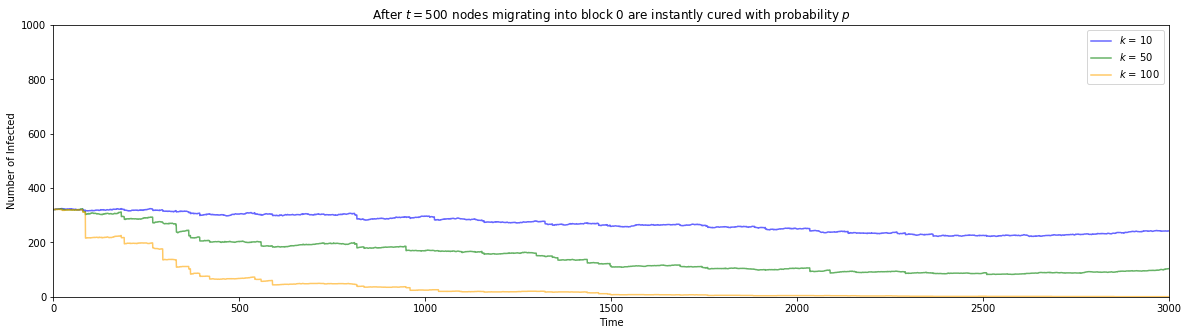

In [44]:
median = np.zeros(shape = (3, max_iter + 1))
for i in range(3):
    for j in range(max_iter + 1):
        median[i, j] = median[i, j] + np.median(results[i, :, j])

plt.rcParams['figure.figsize'] = [20, 5]        
        
plt.title("After $t=500$ nodes migrating into block 0 are instantly cured with probability $p$")
plt.ylim((0,1000))
plt.xlim((0,max_iter + 1))
plt.xlabel("Time")
plt.ylabel("Number of Infected")

time = [i*0.5 for i in range(max_iter + 1)]
    
color_range = ["blue", "green", "orange"] 

for model in range(3):
    plt.plot(time, median[model, :], color = color_range[model], alpha = 0.6)

plt.legend(["$k$ = 10","$k$ = 50","$k$ = 100"])